## Likelihood Ratio for DR1 ##

This notebook has the running of the Likelihood Ratio Code on DR1.

In [1]:
# Imports
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from os.path import exists
from sklearn.neighbors import KernelDensity
import RidgelineFilesDR1 as RLF
from ridge_toolkitDR1 import DefineCutoutHDU, GetAvailableSources, GetCutoutArray
from SourceSearchDR1 import *

In [ ]:
if exists(RLF.psl) == False:
    print('Ridgelines not drawn.  Full Ridgeline code now running. Please wait output will show below.')
    %run 'DR1 - Ridgelines.ipynb'
else:
    print('Ridgeline information present. Please continue')

In [2]:
TotalFluxCut = str(RLF.TFC)
available_sources = GetAvailableSources(TotalFluxCut)
print(available_sources.shape)

(3946, 14)


In [3]:
# Set up source_list to be used in all of the following fuctions/cells
probfile = RLF.psl
source_list = GetSourceList(available_sources, probfile)
#np.savetxt('Catalogue/DR1/source_listDR1Full.csv', source_list, delimiter = ',', fmt='%s', encoding = 'utf-8')
print(len(source_list))

3384


In [ ]:
# Load in the optical/IR and LOFAR catalogues, form tables and df and save as text files 
# Check columns esp on the Opt/IR
# Do not need to run if OptCatdf exists, Yes I do CreateSubCat needs them
OptTable = TableOfSources(str(RLF.OptCat))
Optdf = OptTable.to_pandas()
Optdf.to_csv(RLF.OptCatdf, columns = [str(RLF.IDW), str(RLF.IDP), str(RLF.PossRA), str(RLF.PossDEC), str(RLF.OptMagA), str(RLF.MagAErr), str(RLF.OptMagP), str(RLF.MagPErr)], header = True, index = False)

In [4]:
LofarTable = TableFromLofar(str(RLF.LofCat))
Lofardf = LofarTable.to_pandas()

In [ ]:
# Creating cutouts from the pw table so that it is easier to find the magnitudes for the 30 closest
# Only needs to be done once
for source in source_list:
    for asource in available_sources:
        if source == asource[0]:
            source_name = asource[0]
            lofarra = asource[4].astype(float)
            lofardec = asource[5].astype(float)
            sizepix = asource[6].astype(float)
            
            size = sizepix * RLC.ddel # convert size in pixels to degrees
            subcat = Optdf[(np.abs(Optdf[str(RLF.PossRA)] - lofarra) * np.cos(lofardec * np.pi / 180.0) < size) & (np.abs(Optdf[str(RLF.PossDEC)] - lofardec) < size)].copy()

            # Insert the uniform optical position error if required             
            
            #subcat['raErr'] = np.where(np.isnan(subcat[str(RLF.OptMagP)]), RLF.UniWErr, RLF.UniLErr)
            #subcat['decErr'] = np.where(np.isnan(subcat[str(RLF.OptMagP)]), RLF.UniWErr, RLF.UniLErr)
            
            subcat.to_csv(RLF.MagCO %source_name, columns = [str(RLF.IDW), str(RLF.IDP), str(RLF.PossRA), str(RLF.PossDEC), 'raErr', 'decErr', str(RLF.OptMagA), str(RLF.OptMagP)], header = True, index = False)


In [ ]:
# Looping through all successful sources to create the cutoutcat .txt files.  The distance away to form
# the sub-catalogue is set in RLConstants and is currently set to 1 arcmin RA and 0.5 arcmin DEC.
# Only needs to be done once

source_count = 0 ## Keeps track of where the loop is
for source in source_list:
    for asource in available_sources:
        if source == asource[0]:
            size = asource[6].astype(float)
            lofar_ra, lofar_dec = SourceInfo(source, LofarTable)[:2]
            #lofar_ra = asource[4].astype(float)
            #lofar_dec = asource[5].astype(float)
            subcat1 = CreateSubCat(OptTable, lofar_ra, lofar_dec)
    
            # Insert the uniform optical position error if required
            #subcatdf = subcat1.to_pandas()

            # Insert the uniform optical position error if required             

            #subcatdf['raErr'] = np.where(np.isnan(subcatdf[str(RLF.OptMagP)]), RLF.UniWErr, RLF.UniLErr)
            #subcatdf['decErr'] = np.where(np.isnan(subcatdf[str(RLF.OptMagP)]), RLF.UniWErr, RLF.UniLErr)
            #subcat2 = Table.from_pandas(subcatdf)
    
            cutoutcat = CreateCutOutCat(source, LofarTable, subcat1)
            source_count += 1
            #print('Source Number = ' + str(source_count))

In [ ]:
# Create a table of positional data for hosts
positions = CreatePositionTable(source_list, available_sources, LofarTable)
positions.info()

In [ ]:
# NEEDS TO BE A FUNCTION
# Generates the Host magnitude information
pwfulldf = pd.read_csv(RLF.OptCatdf, header = 0, usecols = ['AllWISE', 'i', 'W1mag'])
pos = pd.read_csv(str(RLF.Position), header = 0, usecols = ['Source_Name', 'AllWISE', 'Host_RA', 'Host_DEC', 'Host_RA_errOpt', 'Host_DEC_errOpt', 'LOFAR_RA_errRad', 'LOFAR_DEC_errRad'])
pwfulldf['AllWISE'] = pwfulldf['AllWISE'].map(lambda x: x.strip('b').strip("''"))
pos['AllWISE'] = pos['AllWISE'].map(lambda x: x.strip('b').strip("''"))

mag = pos.merge(pwfulldf, on = 'AllWISE')

mag['Source_Name'] = mag['Source_Name'].map(lambda x: x.strip('b').strip("''"))
mag.to_csv(str(RLF.DR1Hosts), columns = [ 'Source_Name', 'AllWISE', 'Host_RA', 'Host_DEC', 'LOFAR_RA_errRad', 'LOFAR_DEC_errRad', 'Host_RA_errOpt', 'Host_DEC_errOpt', 'W1mag', 'i'], header = True, index = False)

In [ ]:
# Create a table of R distance information from LOFAR Catalogue position
# Only needs to be done once
for source in source_list:
    CreateLDistTable(source, available_sources)

In [ ]:
# Find the 30 closest sources for each ridgeline
# Only needs to be done once
n = 30
NClosestDistances(source_list, available_sources, LofarTable, n)

In [5]:
# Generating the likelihood ratios for all possible close sources, for each drawn
# ridgeline, using the R distance from LOFAR Catalogue position and the ridgeline.
# Only needs to be done once
GetFr(source_list, available_sources)

In [6]:
# CREATE NEAREST 30 INFO
# Load in the three text files for each source, join all the table information together and save
# Only needs to be done once

for source in source_list:

    LofarLR = pd.read_csv(RLF.LLR %source, header = 0)
    RidgeLR = pd.read_csv(RLF.RLR %source, header = 0, usecols = ['Ridge_LR'])
    MagCutOut = pd.read_csv(RLF.MagCO %source, header = 0, usecols = [str(RLF.IDW), str(RLF.IDP), str(RLF.PossRA), str(RLF.OptMagA), str(RLF.OptMagP)])
    MagCutOut[str(RLF.PossRA)] = MagCutOut[str(RLF.PossRA)].apply(lambda x: round(x, 7))
    MCO = MagCutOut.drop(columns = ['AllWISE'])
            
    All_LR = LofarLR.join(RidgeLR['Ridge_LR'])
    All_LR['Multi_LR'] = np.where(~np.isnan(All_LR['Ridge_LR']), All_LR['Lofar_LR'].astype(np.float64).multiply(All_LR['Ridge_LR'].astype(np.float64), axis = 'index'), All_LR['Lofar_LR'].astype(np.float64))
        
    All_LR.columns=['AllWISE', 'LofarRDis', 'Lofar_LR', str(RLF.PossRA), str(RLF.PossDEC), 'Ridge_LR', 'Multi_LR']
    All_LR[str(RLF.PossRA)] = All_LR[str(RLF.PossRA)].apply(lambda x: round(x, 7))
            
    MagLR = All_LR.merge(MCO, on = str(RLF.PossRA))
            
    MagLR.to_csv(RLF.LRI %source, columns = ['AllWISE', 'LofarRDis', 'Lofar_LR', str(RLF.PossRA), str(RLF.PossDEC), 'Ridge_LR', 'Multi_LR', str(RLF.IDW), str(RLF.IDP), str(RLF.OptMagP), str(RLF.OptMagA)], header = True, index = False)


In [7]:
# Load in Host Info
Hosts = pd.read_csv(str(RLF.DR1Hosts), usecols = [ 'Source_Name', 'AllWISE', 'Host_RA', 'Host_DEC', 'W1mag', 'i'], header = 0)
Hosts['Colour'] = Hosts['i'].astype(np.float64).subtract(Hosts['W1mag'].astype(np.float64), axis = 'index')

In [8]:
# Create the colour column and sample the df
pwfulldf = pd.read_csv(RLF.OptCatdf, header = 0, usecols = ['AllWISE', 'i', 'W1mag'])
ColourPW = pwfulldf[~np.isnan(pwfulldf['i']) & ~np.isnan(pwfulldf['W1mag'])].copy()
ColourPW.reset_index(drop = True, inplace = True)

ColourPW['Colour'] = ColourPW['i'].subtract(ColourPW['W1mag'], axis = 'index')
ColSam = ColourPW.sample(50000, replace = False)

In [9]:
# Skyarea Covered byt he LOFAR data set
area = (np.deg2rad(RLC.LRAu) - np.deg2rad(RLC.LRAd)) * (np.sin(np.deg2rad(RLC.LDECu)) - np.sin(np.deg2rad(RLC.LDECd))) * np.rad2deg(3600)**2
print(area)

11431476680.687202


In [10]:
# Not running on i-band so only need the W1 band cells
hh, ww1 = np.mgrid[Hosts['Colour'].min() : Hosts['Colour'].max() : 0.05, Hosts['W1mag'].min() : Hosts['W1mag'].max() : 0.05]
h_sample = np.vstack([ww1.ravel(), hh.ravel()]).T
h_train = np.vstack([Hosts['W1mag'], Hosts['Colour']]).T
kde_h = KernelDensity(kernel = 'gaussian', bandwidth = RLC.bw)
kde_h.fit(h_train)
prob_h = np.exp(kde_h.score_samples(h_sample))
norm_h = len(Hosts['W1mag'])/np.sum(prob_h)

In [11]:
oo, ww2 = np.mgrid[ColSam['Colour'].min() : ColSam['Colour'].max() : 0.05, ColSam['W1mag'].min() : ColSam['W1mag'].max() : 0.05]
o_sample = np.vstack([ww2.ravel(), oo.ravel()]).T
o_train = np.vstack([ColSam['W1mag'], ColSam['Colour']]).T
kde_o = KernelDensity(kernel = 'gaussian', bandwidth = RLC.bw)
kde_o.fit(o_train)
prob_o = np.exp(kde_o.score_samples(o_sample))
norm_o = len(ColSam['W1mag'])/np.sum(prob_o)

In [12]:
# functions needed

def GetLR(fr, qm, nm):
    lr = (fr * qm) / nm
    return lr

def Getqmc(m, c):
    qmc = np.exp(kde_h.score_samples(np.array([m, c]).reshape(1, -1)))
    return qmc * norm_h

def Getnmc(m, c):
    nmc = np.exp(kde_o.score_samples(np.array([m, c]).reshape(1, -1)))
    return (nmc/area) * norm_o

In [13]:
# Calculating the LR from the text files for the W1 band hosts

for source in source_list:
            
    #MLRhw = pd.read_csv(str(RLF.NLRI) %source, header = 0, usecols = ['AllWise', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'SBLR', 'Multi_LR',  'i', 'W1mag'])
    MLR = pd.read_csv(str(RLF.LRI) %source, header = 0, usecols = ['AllWISE', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'Multi_LR',  'i', 'W1mag'])
    MLR['Colour'] = MLR['i'].subtract(MLR['W1mag'], axis = 'index')
    MCLR = MLR[~np.isnan(MLR['Colour'])].copy()
    MCLR['MCLLR'] = MCLR.apply(lambda row: GetLR(row['Lofar_LR'], Getqmc(row['W1mag'], row['Colour']), Getnmc(row['W1mag'], row['Colour'])), axis = 1).astype(np.float128)
    MCLR['MCRLR'] = MCLR.apply(lambda row: GetLR(row['Ridge_LR'], Getqmc(row['W1mag'], row['Colour']), Getnmc(row['W1mag'], row['Colour'])), axis = 1).astype(np.float128)
    #MCLRhw['MCSBLR'] = MCLRhw.apply(lambda row: GetLR(row['SBLR'], Getqmcw(row['W1mag'], row['Colour']), Getnmcw(row['W1mag'], row['Colour'])), axis = 1).astype(np.float128)
    MCLR['MCMLR'] = MCLR.apply(lambda row: GetLR(row['Multi_LR'], Getqmc(row['W1mag'], row['Colour']), Getnmc(row['W1mag'], row['Colour'])), axis = 1).astype(np.float128)
            
    #MCLRhw.to_csv(str(RLF.MCLR) %source, columns = ['AllWise', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'SBLR', 'Multi_LR',  'i', 'W1mag', 'MCLLR', 'MCRLR', 'MCSBLR', 'MCMLR'], header = True, index = False)
    MCLR.to_csv(str(RLF.LR) %source, columns = ['AllWISE', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'Multi_LR',  'i', 'W1mag', 'MCLLR', 'MCRLR', 'MCMLR'], header = True, index = False)

In [14]:
# Find the max LR in each column and then count up how many correct hosts found using the KDE method for the i band

Sources = pd.read_csv(str(RLF.Position), header = None, usecols = [0, 1], names = ['Source_Name', 'AllWISE'])
Sources['Source_Name'] = Sources['Source_Name'].map(lambda x: x.strip('b').strip("''"))
Sources['AllWISE'] = Sources['AllWISE'].map(lambda x: x.strip('b').strip("''"))
Lofar_tot = 0
Ridge_tot = 0
Either_tot = 0
Multi_tot = 0
Successful = []
odd = []
LC = 0
RC = 0
LRC = 0
NC = 0
MLRC = 0

for source in source_list:

    #MCLRhw = pd.read_csv(str(RLF.MCLR) %source, header = 0, usecols = ['AllWise', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'SBLR', 'Multi_LR',  'i', 'W1mag', 'MCLLR', 'MCRLR', 'MCSBLR', 'MCMLR'])
    MCLR = pd.read_csv(str(RLF.LR) %source, header = 0, usecols = ['AllWISE', 'LofarRDis', 'ra', 'dec', 'Lofar_LR', 'Ridge_LR', 'Multi_LR',  'i', 'W1mag', 'MCLLR', 'MCRLR', 'MCMLR'])
    MCLR['AllWISE'] = MCLR['AllWISE'].map(lambda x: x.strip('b').strip("''"))
            
    MaxLofarLR = MCLR.loc[MCLR['MCLLR'].idxmax()][0]
    MaxRidgeLR = MCLR.loc[MCLR['MCRLR'].idxmax()][0]
    #MaxSBLRhw = MCLRhw.loc[MCLRhw['MCSBLR'].idxmax()][0]
    MaxMultiLR = MCLR.loc[MCLR['MCMLR'].idxmax()][0]

    Sources['Lofar_Count'] = Sources['AllWISE'].apply(lambda x: 1 if x == MaxLofarLR else 0)
    Sources['Ridge_Count'] = Sources['AllWISE'].apply(lambda x: 1 if x == MaxRidgeLR else 0)
    #Sources['Surface_Count'] = Sources['AllWISE'].apply(lambda x: 1 if x == MaxSBLRhw else 0)
    Sources['Multi_Count'] = Sources['AllWISE'].apply(lambda x: 1 if x == MaxMultiLR else 0)
            
    Lofar_tot += Sources['Lofar_Count'].sum()
    Ridge_tot += Sources['Ridge_Count'].sum()
    #Surface_tot += Sources['Surface_Count'].sum()
    Multi_tot += Sources['Multi_Count'].sum()
    
    if Sources['Multi_Count'].sum() > 0:
        aw = (Sources['AllWISE'].loc[Sources['Multi_Count'] == 1]).values[0]
        sn = (Sources['Source_Name'].loc[Sources['AllWISE'] == aw]).values[0]
        if sn == source:
            Successful.append(str(sn))
        else:
            print('sn = ' + str(sn))
            print('source = ' + str(source))
            odd.append(sn) ## It has found a host but the wrong one so not considered a success

    
    if Sources['Lofar_Count'].sum() > 0 or Sources['Ridge_Count'].sum() > 0:
        Either_tot += 1
        
    if (Sources['Lofar_Count'].sum() > 0 and Sources['Ridge_Count'].sum() > 0) and Sources['Multi_Count'].sum() > 0:
        MLRC += 1
        
    if Sources['Lofar_Count'].sum() > 0 and Sources['Ridge_Count'].sum() > 0:
        LRC +=1
    elif Sources['Ridge_Count'].sum() > 0 and Sources['Lofar_Count'].sum() == 0:
        RC += 1
    elif Sources['Lofar_Count'].sum() > 0 and Sources['Ridge_Count'].sum() == 0:
        LC += 1
    else:
        NC += 1

print('LRC = ', LRC, 'RC = ', RC, 'LC = ', LC, 'NC = ', NC, 'MLRC = ', MLRC)
print(odd)
NoHosts = source_list.copy()
Fails = [j for j in NoHosts if j not in Successful]
print('Number of Successfuls = ' + str(len(Successful)))
print('Numbers of Fails = ' + str(len(Fails)))
    
#np.savetxt('Catalogue/Successful950L.csv', Successful, fmt='%s', encoding = 'utf-8', delimiter = ',')
#np.savetxt('Catalogue/Fails950L.csv', Fails, fmt='%s', encoding = 'utf-8', delimiter = ',')
print('Number of correctly found hosts with the Lofar Distance using W1 band =', Lofar_tot - len(odd))
print('Number of correctly found hosts with the Ridge Distance using W1 band =', Ridge_tot - len(odd))
print('Number of correctly found hosts with the Multiplied Distance using W1 band =', Multi_tot)
print('Number of correctly found hosts with the Either Distance using W1 band =', Either_tot - len(odd))

sn = ILTJ123458.21+531853.6
source = ILTJ123459.82+531851.0
LRC =  3129 RC =  88 LC =  101 NC =  66 MLRC =  3129
['ILTJ123458.21+531853.6']
Number of Successfuls = 3261
Numbers of Fails = 123
Number of correctly found hosts with the Lofar Distance using W1 band = 3229
Number of correctly found hosts with the Ridge Distance using W1 band = 3216
Number of correctly found hosts with the Multiplied Distance using W1 band = 3262
Number of correctly found hosts with the Either Distance using W1 band = 3317


Text(0.5, 1.0, 'Correctly Found Hosts Using Each Separation')

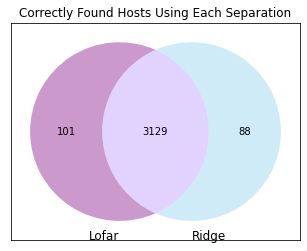

In [15]:
from matplotlib_venn import venn2, venn2_unweighted
import matplotlib.pyplot as plt
Lc = LC - LRC
Rc = RC - LRC

vL = venn2_unweighted(subsets = (LC, RC, LRC), set_labels = ('Lofar', 'Ridge'), set_colors = ('purple', 'skyblue'))
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.title('Correctly Found Hosts Using Each Separation')